In [1]:
!pip install pypulseq &> /dev/null
!pip install MRzeroCore &> /dev/null
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null

(EPI_2D_seq)=
# 2D EPI

Calculating repetition 1 / 1 - done


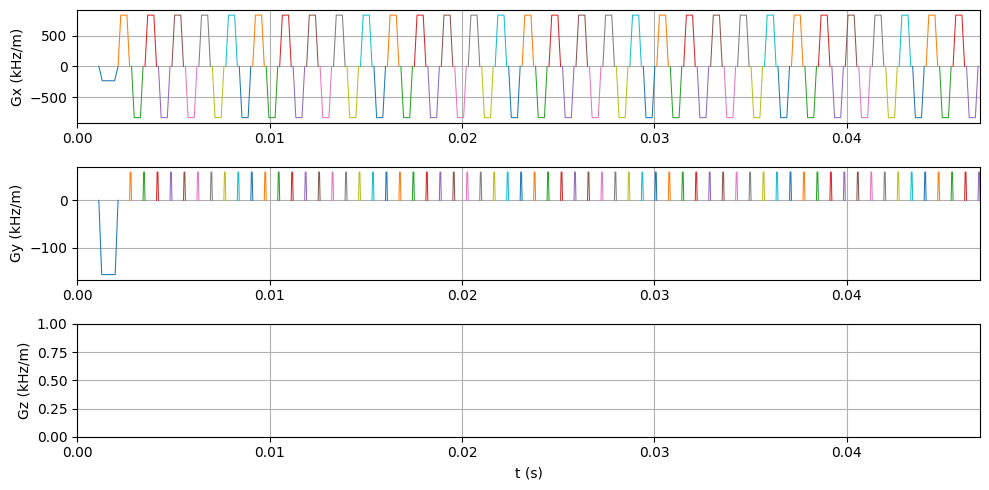

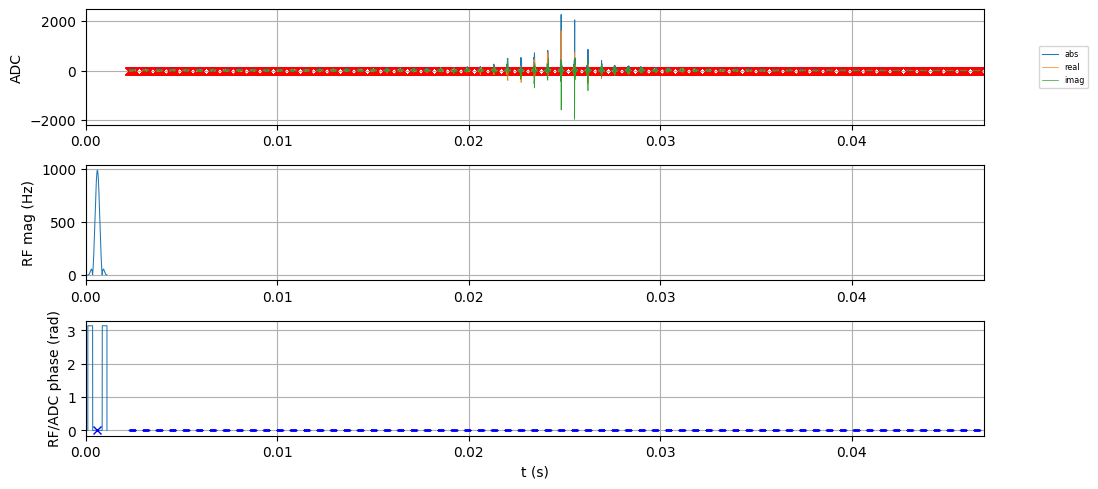

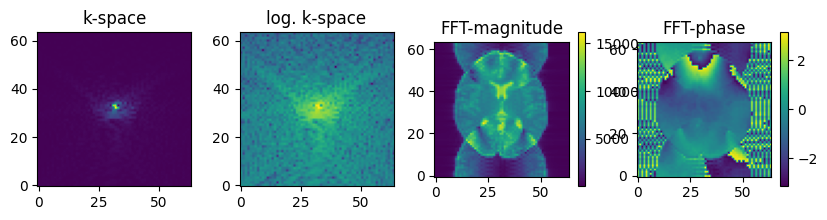

In [2]:
import numpy as np
import MRzeroCore as mr0
import pypulseq as pp
import torch
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

experiment_id = 'exB09_GRE_EPI_2D'

# %% S1. SETUP sys

# choose the scanner limits
system = pp.Opts(
    max_grad=28, grad_unit='mT/m', max_slew=150, slew_unit='T/m/s',
    rf_ringdown_time=20e-6, rf_dead_time=100e-6,
    adc_dead_time=20e-6, grad_raster_time=10e-6
)

# %% S2. DEFINE the sequence
seq = pp.Sequence()

# Define FOV and resolution
fov = 240e-3
slice_thickness = 8e-3
sz = (64, 64)   # spin system size / resolution
Nread = 64    # frequency encoding steps/samples
Nphase = 64    # phase encoding steps/samples

# Define rf events
rf1, _, _ = pp.make_sinc_pulse(
    flip_angle=90 * np.pi / 180, duration=1e-3,
    slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
    system=system, return_gz=True
)

# Define other gradients and ADC events
adc_duration_OG = 0.25e-3 # @param {type: "slider", min: 0.25e-3, max: 10e-3, step: 0.05e-3}
a = int(system.adc_raster_time * Nread * 10**7)
b = int(system.grad_raster_time * 10**7)
c = int(adc_duration_OG * 10**7)
lcm_ab = abs(a * b) // np.gcd(a, b)
adc_raster_duration = (lcm_ab if round(c / lcm_ab) == 0 else round(c / lcm_ab) * lcm_ab) / 10**7

eddy_currents=True # @param {type:"boolean"}
eddy_currents_induced_delay= 0.0000015 # @param {type: "slider", min: -1e-4, max: 1e-4, step: 1e-8}
eddy_currents_induced_delay*=eddy_currents

gx = pp.make_trapezoid(channel='x', flat_area=Nread / fov, flat_time=adc_raster_duration, system=system)
gx_ = pp.make_trapezoid(channel='x', flat_area=-Nread / fov, flat_time=adc_raster_duration, system=system)
adc = pp.make_adc(num_samples=Nread, duration=adc_raster_duration, phase_offset=0 * np.pi / 180, delay=gx.rise_time + eddy_currents_induced_delay, system=system)
gx_pre = pp.make_trapezoid(channel='x', area=-gx.area / 2, duration=1e-3, system=system)

# ======
# CONSTRUCT SEQUENCE
# ======
blip_duration=0.1e-3 # @param {type: "slider", min: 0.1e-3, max: 50e-3, step: 0.05e-3}
gp_blip = pp.make_trapezoid(channel='y', area=1 / fov, duration=blip_duration, system=system)

seq.add_block(rf1)
gp = pp.make_trapezoid(channel='y', area=-Nphase//2 / fov, duration=1e-3, system=system)
seq.add_block(gx_pre, gp)

for ii in range(0, Nphase//2):
    seq.add_block(gx,adc)
    seq.add_block(gp_blip)
    seq.add_block(gx_,adc)
    seq.add_block(gp_blip)

#quick 2D brain phantom sim and plot
signal = mr0.util.simulate_2d(seq)
seq.plot(plot_now=False)
mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
plt.show()

# %% S6: MR IMAGE RECON of signal ::: #####################################
fig = plt.figure(figsize=(10,2))  # fig.clf()

kspace_adc = torch.reshape((signal), (Nphase, Nread)).clone().t()
kspace = kspace_adc
kspace[:,0::2] = torch.flip(kspace[:,0::2],[0] )[:,:]
# fftshift FFT fftshift
spectrum = torch.fft.fftshift(kspace)
space = torch.fft.fft2(spectrum)
space = torch.fft.ifftshift(space)

plt.subplot(141)
plt.title('k-space')
mr0.util.imshow(np.abs(kspace.numpy()))
plt.subplot(142)
plt.title('log. k-space')
mr0.util.imshow(np.log(np.abs(kspace.numpy())))

plt.subplot(143)
plt.title('FFT-magnitude')
mr0.util.imshow(np.abs(space.numpy()))
plt.colorbar()
plt.subplot(144)
plt.title('FFT-phase')
mr0.util.imshow(np.angle(space.numpy()), vmin=-np.pi, vmax=np.pi)
plt.colorbar()

In [3]:
gx

namespace(type='trap',
          channel='x',
          amplitude=np.float64(833333.3333333334),
          rise_time=0.00014000000000000001,
          flat_time=np.float64(0.00032),
          fall_time=0.00014000000000000001,
          area=np.float64(383.3333333333334),
          flat_area=np.float64(266.6666666666667),
          delay=0,
          first=0,
          last=0)

In [2]:
# @title Export sequence as .seq file

# Check whether the timing of the sequence is correct
ok, error_report = seq.check_timing()
if ok:
    print('Timing check passed successfully')
else:
    print('Timing check failed. Error listing follows:')
    [print(e) for e in error_report]

# Prepare the sequence output for the scanner
seq.set_definition('FOV', [fov, fov, slice_thickness])
seq.set_definition('Name', 'gre')
seq_write_signature = seq.write(experiment_id + '.seq')

Timing check failed. Error listing follows:
Event: 3 - [type: adc delay: 141.50000000000003 us dwell: 5000.0 ns]

Event: 5 - [type: adc delay: 141.50000000000003 us dwell: 5000.0 ns]

Event: 7 - [type: adc delay: 141.50000000000003 us dwell: 5000.0 ns]

Event: 9 - [type: adc delay: 141.50000000000003 us dwell: 5000.0 ns]

Event: 11 - [type: adc delay: 141.50000000000003 us dwell: 5000.0 ns]

Event: 13 - [type: adc delay: 141.50000000000003 us dwell: 5000.0 ns]

Event: 15 - [type: adc delay: 141.50000000000003 us dwell: 5000.0 ns]

Event: 17 - [type: adc delay: 141.50000000000003 us dwell: 5000.0 ns]

Event: 19 - [type: adc delay: 141.50000000000003 us dwell: 5000.0 ns]

Event: 21 - [type: adc delay: 141.50000000000003 us dwell: 5000.0 ns]

Event: 23 - [type: adc delay: 141.50000000000003 us dwell: 5000.0 ns]

Event: 25 - [type: adc delay: 141.50000000000003 us dwell: 5000.0 ns]

Event: 27 - [type: adc delay: 141.50000000000003 us dwell: 5000.0 ns]

Event: 29 - [type: adc delay: 141.500

# Phantom changes

If you alter phantom parameters between

```
obj_p = mr0.VoxelGridPhantom.load_mat('numerical_brain_cropped.mat')
obj_p = obj_p.interpolate(sz[0], sz[1], 1)
```
and
```
obj_p = obj_p.build()
```

you can alter the object manually to study phase images or distortions.

In [19]:
def create_undersampling_mask(kspace_shape, acceleration_factor, center_fraction=0.08):
    """
    Create an undersampling mask for k-space data using regular column-wise sampling pattern.
    
    Parameters:
    -----------
    kspace_shape : tuple
        Shape of the k-space data (height, width)
    acceleration_factor : float
        Desired acceleration factor (R). Must be >= 1.0
    center_fraction : float, optional
        Fraction of center k-space to fully sample (default: 0.08)
        
    Returns:
    --------
    mask : numpy.ndarray
        Binary mask of same shape as input k-space
    """
    if acceleration_factor < 1.0:
        raise ValueError("Acceleration factor must be >= 1.0")
    
    num_rows, num_cols = kspace_shape
    mask = np.zeros(kspace_shape, dtype=np.float32)
    
    # Calculate number of center columns to keep
    num_center_cols = int(num_cols * center_fraction)
    center_start = (num_cols - num_center_cols) // 2
    center_end = center_start + num_center_cols
    
    # Fully sample the center columns
    mask[:, center_start:center_end] = 1.0
    
    # Regular sampling for outer k-space: take 1 column, skip (R-1) columns
    # For columns before the center
    for j in range(0, center_start, int(acceleration_factor)):
        mask[:, j] = 1.0
        
    # For columns after the center
    for j in range(center_end, num_cols, int(acceleration_factor)):
        mask[:, j] = 1.0
    
    return mask

Calculating repetition 1 / 1 - done


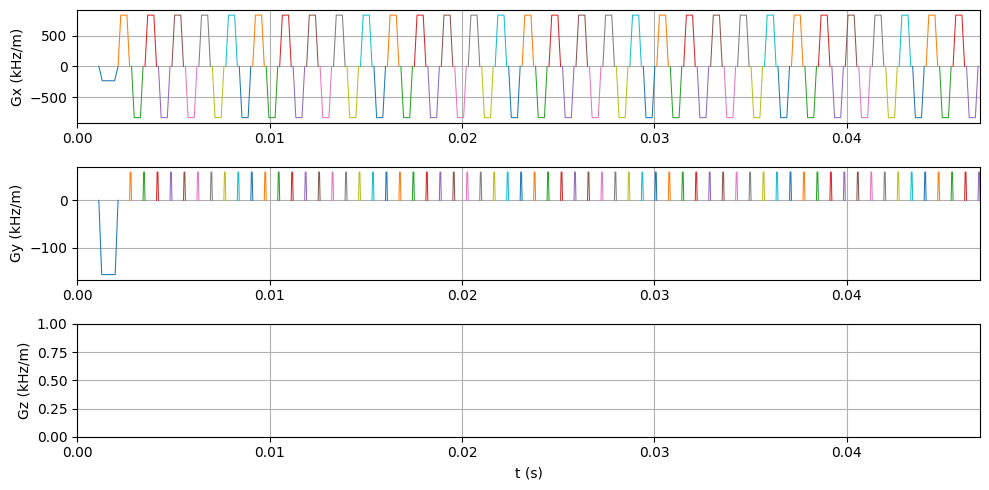

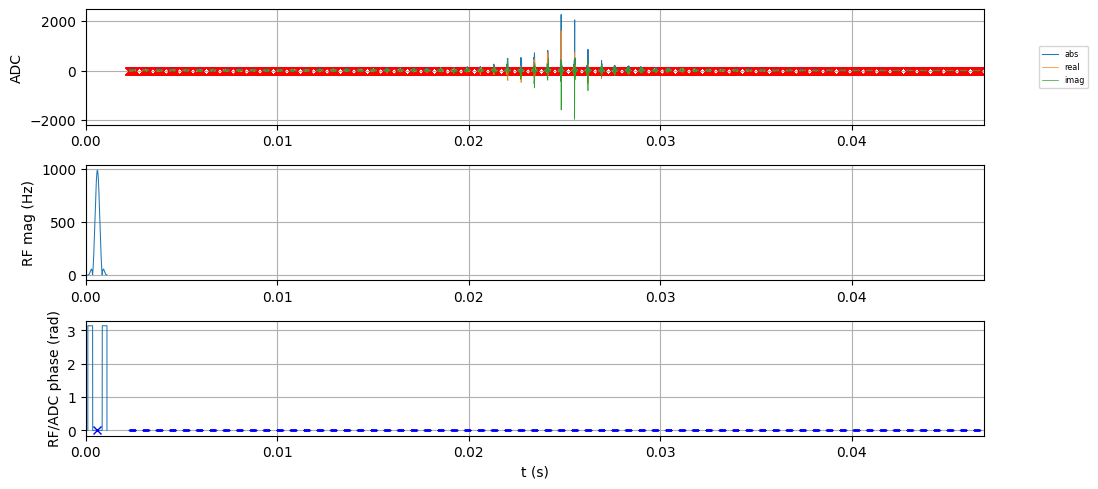

C:\Users\perez\AppData\Local\Temp\ipykernel_8568\110190394.py:85: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  kspace*=mask


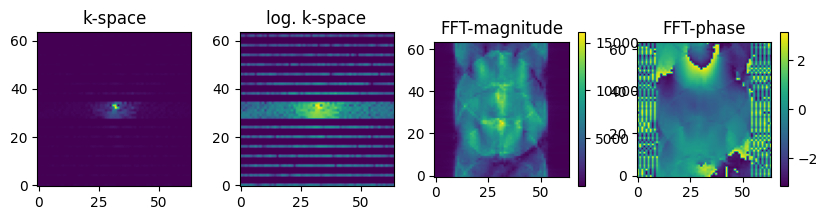

In [20]:
import numpy as np
import MRzeroCore as mr0
import pypulseq as pp
import torch
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

experiment_id = 'exB09_GRE_EPI_2D'

# %% S1. SETUP sys

# choose the scanner limits
system = pp.Opts(
    max_grad=28, grad_unit='mT/m', max_slew=150, slew_unit='T/m/s',
    rf_ringdown_time=20e-6, rf_dead_time=100e-6,
    adc_dead_time=20e-6, grad_raster_time=10e-6
)

# %% S2. DEFINE the sequence
seq = pp.Sequence()

# Define FOV and resolution
fov = 240e-3
slice_thickness = 8e-3
sz = (64, 64)   # spin system size / resolution
Nread = 64    # frequency encoding steps/samples
Nphase = 64    # phase encoding steps/samples

# Define rf events
rf1, _, _ = pp.make_sinc_pulse(
    flip_angle=90 * np.pi / 180, duration=1e-3,
    slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
    system=system, return_gz=True
)

# Define other gradients and ADC events
adc_duration_OG = 0.25e-3 # @param {type: "slider", min: 0.25e-3, max: 10e-3, step: 0.05e-3}
a = int(system.adc_raster_time * Nread * 10**7)
b = int(system.grad_raster_time * 10**7)
c = int(adc_duration_OG * 10**7)
lcm_ab = abs(a * b) // np.gcd(a, b)
adc_raster_duration = (lcm_ab if round(c / lcm_ab) == 0 else round(c / lcm_ab) * lcm_ab) / 10**7

eddy_currents=True # @param {type:"boolean"}
eddy_currents_induced_delay= 0.0000015 # @param {type: "slider", min: -1e-4, max: 1e-4, step: 1e-8}
eddy_currents_induced_delay*=eddy_currents

gx = pp.make_trapezoid(channel='x', flat_area=Nread / fov, flat_time=adc_raster_duration, system=system)
gx_ = pp.make_trapezoid(channel='x', flat_area=-Nread / fov, flat_time=adc_raster_duration, system=system)
adc = pp.make_adc(num_samples=Nread, duration=adc_raster_duration, phase_offset=0 * np.pi / 180, delay=gx.rise_time + eddy_currents_induced_delay, system=system)
gx_pre = pp.make_trapezoid(channel='x', area=-gx.area / 2, duration=1e-3, system=system)

# ======
# CONSTRUCT SEQUENCE
# ======
blip_duration=0.1e-3 # @param {type: "slider", min: 0.1e-3, max: 50e-3, step: 0.05e-3}
gp_blip = pp.make_trapezoid(channel='y', area=1 / fov, duration=blip_duration, system=system)

seq.add_block(rf1)
gp = pp.make_trapezoid(channel='y', area=-Nphase//2 / fov, duration=1e-3, system=system)
seq.add_block(gx_pre, gp)

for ii in range(0, Nphase//2):
    seq.add_block(gx,adc)
    seq.add_block(gp_blip)
    seq.add_block(gx_,adc)
    seq.add_block(gp_blip)

#quick 2D brain phantom sim and plot
signal = mr0.util.simulate_2d(seq)
seq.plot(plot_now=False)
mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
plt.show()

# %% S6: MR IMAGE RECON of signal ::: #####################################
fig = plt.figure(figsize=(10,2))  # fig.clf()

kspace_adc = torch.reshape((signal), (Nphase, Nread)).clone().t()
kspace = kspace_adc
kspace[:,0::2] = torch.flip(kspace[:,0::2],[0] )[:,:]

mask = create_undersampling_mask(kspace.shape, acceleration_factor=4)
kspace*=mask
# fftshift FFT fftshift
spectrum = torch.fft.fftshift(kspace)
space = torch.fft.fft2(spectrum)
space = torch.fft.ifftshift(space)

plt.subplot(141)
plt.title('k-space')
mr0.util.imshow(np.abs(kspace.numpy()))
plt.subplot(142)
plt.title('log. k-space')
mr0.util.imshow(np.log(np.abs(kspace.numpy()) + 1))

plt.subplot(143)
plt.title('FFT-magnitude')
mr0.util.imshow(np.abs(space.numpy()))
plt.colorbar()
plt.subplot(144)
plt.title('FFT-phase')
mr0.util.imshow(np.angle(space.numpy()), vmin=-np.pi, vmax=np.pi)
plt.colorbar()

Calculating repetition 1 / 1 - done


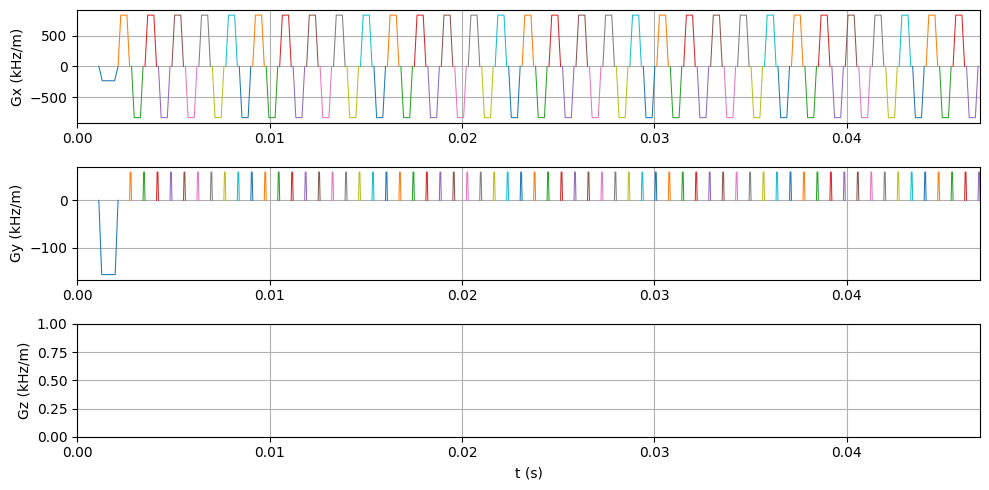

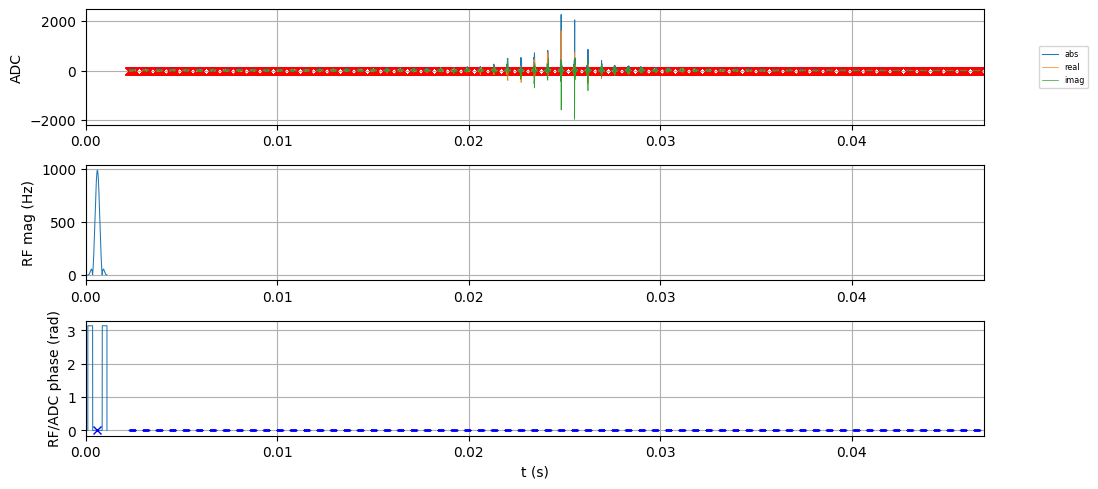

C:\Users\perez\AppData\Local\Temp\ipykernel_8568\110190394.py:85: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  kspace*=mask


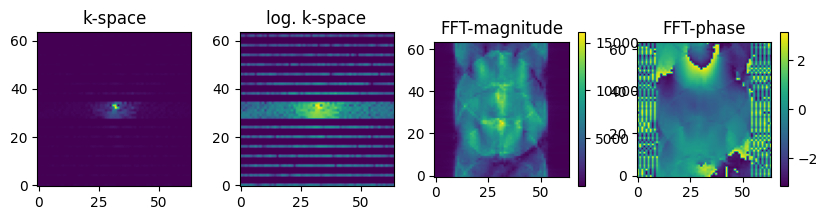

In [20]:
import numpy as np
import MRzeroCore as mr0
import pypulseq as pp
import torch
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

experiment_id = 'exB09_GRE_EPI_2D'

# %% S1. SETUP sys

# choose the scanner limits
system = pp.Opts(
    max_grad=28, grad_unit='mT/m', max_slew=150, slew_unit='T/m/s',
    rf_ringdown_time=20e-6, rf_dead_time=100e-6,
    adc_dead_time=20e-6, grad_raster_time=10e-6
)

# %% S2. DEFINE the sequence
seq = pp.Sequence()

# Define FOV and resolution
fov = 240e-3
slice_thickness = 8e-3
sz = (64, 64)   # spin system size / resolution
Nread = 64    # frequency encoding steps/samples
Nphase = 64    # phase encoding steps/samples

# Define rf events
rf1, _, _ = pp.make_sinc_pulse(
    flip_angle=90 * np.pi / 180, duration=1e-3,
    slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
    system=system, return_gz=True
)

# Define other gradients and ADC events
adc_duration_OG = 0.25e-3 # @param {type: "slider", min: 0.25e-3, max: 10e-3, step: 0.05e-3}
a = int(system.adc_raster_time * Nread * 10**7)
b = int(system.grad_raster_time * 10**7)
c = int(adc_duration_OG * 10**7)
lcm_ab = abs(a * b) // np.gcd(a, b)
adc_raster_duration = (lcm_ab if round(c / lcm_ab) == 0 else round(c / lcm_ab) * lcm_ab) / 10**7

eddy_currents=True # @param {type:"boolean"}
eddy_currents_induced_delay= 0.0000015 # @param {type: "slider", min: -1e-4, max: 1e-4, step: 1e-8}
eddy_currents_induced_delay*=eddy_currents

gx = pp.make_trapezoid(channel='x', flat_area=Nread / fov, flat_time=adc_raster_duration, system=system)
gx_ = pp.make_trapezoid(channel='x', flat_area=-Nread / fov, flat_time=adc_raster_duration, system=system)
adc = pp.make_adc(num_samples=Nread, duration=adc_raster_duration, phase_offset=0 * np.pi / 180, delay=gx.rise_time + eddy_currents_induced_delay, system=system)
gx_pre = pp.make_trapezoid(channel='x', area=-gx.area / 2, duration=1e-3, system=system)

# ======
# CONSTRUCT SEQUENCE
# ======
blip_duration=0.1e-3 # @param {type: "slider", min: 0.1e-3, max: 50e-3, step: 0.05e-3}
gp_blip = pp.make_trapezoid(channel='y', area=1 / fov, duration=blip_duration, system=system)

seq.add_block(rf1)
gp = pp.make_trapezoid(channel='y', area=-Nphase//2 / fov, duration=1e-3, system=system)
seq.add_block(gx_pre, gp)

for ii in range(0, Nphase//2):
    seq.add_block(gx,adc)
    seq.add_block(gp_blip)
    seq.add_block(gx_,adc)
    seq.add_block(gp_blip)

#quick 2D brain phantom sim and plot
signal = mr0.util.simulate_2d(seq)
seq.plot(plot_now=False)
mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
plt.show()

# %% S6: MR IMAGE RECON of signal ::: #####################################
fig = plt.figure(figsize=(10,2))  # fig.clf()

kspace_adc = torch.reshape((signal), (Nphase, Nread)).clone().t()
kspace = kspace_adc
kspace[:,0::2] = torch.flip(kspace[:,0::2],[0] )[:,:]

mask = create_undersampling_mask(kspace.shape, acceleration_factor=4)
kspace*=mask
# fftshift FFT fftshift
spectrum = torch.fft.fftshift(kspace)
space = torch.fft.fft2(spectrum)
space = torch.fft.ifftshift(space)

plt.subplot(141)
plt.title('k-space')
mr0.util.imshow(np.abs(kspace.numpy()))
plt.subplot(142)
plt.title('log. k-space')
mr0.util.imshow(np.log(np.abs(kspace.numpy()) + 1))

plt.subplot(143)
plt.title('FFT-magnitude')
mr0.util.imshow(np.abs(space.numpy()))
plt.colorbar()
plt.subplot(144)
plt.title('FFT-phase')
mr0.util.imshow(np.angle(space.numpy()), vmin=-np.pi, vmax=np.pi)
plt.colorbar()